# Unsupervised anomaly detection (fraud) algorithm

In [3]:
from datetime import datetime
start_time = datetime.now()

from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

In [4]:
%%time
data = pd.read_csv('NY property data.csv')
NY_data_orig = data.copy()
data.shape

CPU times: user 2.14 s, sys: 437 ms, total: 2.58 s
Wall time: 2.65 s


(1070994, 32)

In [5]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [6]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


## Remove some properties that we aren't interested in

In [7]:
numrecords_orig = len(data)
numrecords = numrecords_orig
numrecords

1070994

In [8]:
#remove the records with easement type as goverment 
data = data[data["EASEMENT"] != "U"].reset_index(drop=True)
numremoved = numrecords - len(data)
print('# records removed:', numremoved)

# records removed: 1


In [9]:
# create some words for the owner name that might be goverment or a cemetery
gov_list = ['DEPT ', 'DEPARTMENT', 'UNITED STATES','GOVERNMENT',' GOVT ', 'CEMETERY']

# owner = list(set(data['OWNER'].to_list()))
# owner.pop(0) #remove the nan

owner1 = list(set(data['OWNER'].to_list()))
owner = [item for item in owner1 if str(item) != 'nan'] # remove any nan's

remove_list = []
print("Total owner number before removing is ", len(owner))

for i in owner:
   for g in gov_list:
    if g in i and 'STORES' not in i:
        remove_list.append(i)

Total owner number before removing is  863347


In [10]:
remove_list # check all the name here and edit if it is not a goverment name 

['GOVERNMENT/MALAYSIA',
 'DEPARTMENT OF JUVENIL',
 'GOVERNMENT OF TURKEY',
 'NYS DEPT OF ENV. CONS',
 'DEPT PUBLIC WORKS',
 'DEPARTMENT OF BUSINES',
 'UNITED STATES A VA',
 'N Y C DEPT PUBLIC WK',
 'GOVERNMENT OF THE PEO',
 'LUTHERAN CEMETERY',
 'NYC DEPT OF W S G E',
 'U S GOVT POST OFFIC',
 'DEPT OF HOUSING PRESE',
 'GOVERNMENT KNGDM LESO',
 'GOVERNMENT OF THE RUS',
 'FEDERAL GOVERNMENT (G',
 'DEPT  WATER RESOURCE',
 'NYS DEPT PUB WKS',
 'LAW DEPARTMENT',
 'GOVERNMENT/THE ETC',
 'U S GOVT INTERIOR',
 'DEPT OF HIGHWAY',
 'EVERGREEN CEMETERY',
 'DEPT OF CULTURAL AFFA',
 'NYC DEPT WATER RESOUR',
 'THE GOVERNMENT OF COT',
 'UNITED STATES TRUST C',
 'NYS DEPT TRANSPORT',
 'GOVERNMENT OF GUINEA',
 'NYC DEPT OF GEN SERV',
 'DEPT OF HWAYS',
 'GOVERNMENT OF MEXICO',
 'UNITED STATES/AMER/A/',
 'DEPARTMENT OF HOUSING',
 'UNITED STATES POSTALS',
 'DEPT OF TRANSPORTATIO',
 'N Y C DEPT OF HIGHWAY',
 'ELMWIER CEMETERY ASOC',
 'GOVERNMENT REP/SINGAP',
 'NYC DEPT PUBLIC WORKS',
 'ST RAYMONDS CEMETERY

In [11]:
# Look at the most frequent owners. This might show some other properties we aren't interested in.
remove_list2 = data['OWNER'].value_counts().head(20).index.tolist()
remove_list2

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

In [12]:
# add some others to also be removed
remove_list2.append('THE CITY OF NEW YORK')
remove_list2.append('NYS URBAN DEVELOPMENT')
remove_list2.append('CULTURAL AFFAIRS')
remove_list2.append('NY STATE PUBLIC WORKS')
remove_list2.append("NYC DEP'T OF HIGHWAYS")
remove_list2.append('CITY WIDE ADMINISTRAT')
remove_list2.append('NEW YORK CITY')
remove_list2.append('THE PORT OFNY & NJ')
remove_list2.append('NEW YORK STATE DEPART')
remove_list2.append('CITY AND NON-CITY OWN')
remove_list2.append('SANITATION')
remove_list2.append('NYS DOT')
remove_list2.append('NEW YORK CITY TRANSIT')
remove_list2.append('PORT AUTHORITY OF NY')
remove_list2.append('NEW YORK STATE OWNED')
remove_list2.append('NYC PARK DEPT')
remove_list2.append('PORT OF NEW YORK AUTH')
remove_list2.append('NYC PARK DEPT')
remove_list2.append('LIRR')
remove_list2.append('NY STATE PUBLIC SERV')
remove_list2.append('STATE OF NEW YORK')
remove_list2.append('NYC HIGHWAY DEPT')

In [13]:
for i in remove_list2:
    if i not in remove_list:
        remove_list.append(i)
    else:
        print(i)

DEPT OF ENVIRONMENTAL
DEPARTMENT OF BUSINES
DEPT OF TRANSPORTATIO
NYC PARK DEPT


In [14]:
# rremove some of the removes...
remove_list.remove('YORKVILLE TOWERS ASSO')
remove_list.remove('434 M LLC')
remove_list.remove('DEUTSCHE BANK NATIONA')
remove_list.remove('561 11TH AVENUE TMG L')
remove_list.remove('MH RESIDENTIAL 1, LLC')

In [15]:
len(remove_list)

263

In [16]:
numrecords = len(data)
removed = data[data['OWNER'].isin(remove_list)].reset_index(drop=True)
data = data[~data['OWNER'].isin(remove_list)].reset_index(drop=True)
numremoved = numrecords - len(data)
print('# records removed:', numremoved)

# records removed: 26500


In [17]:
removed.shape

(26500, 32)

<Axes: ylabel='OWNER'>

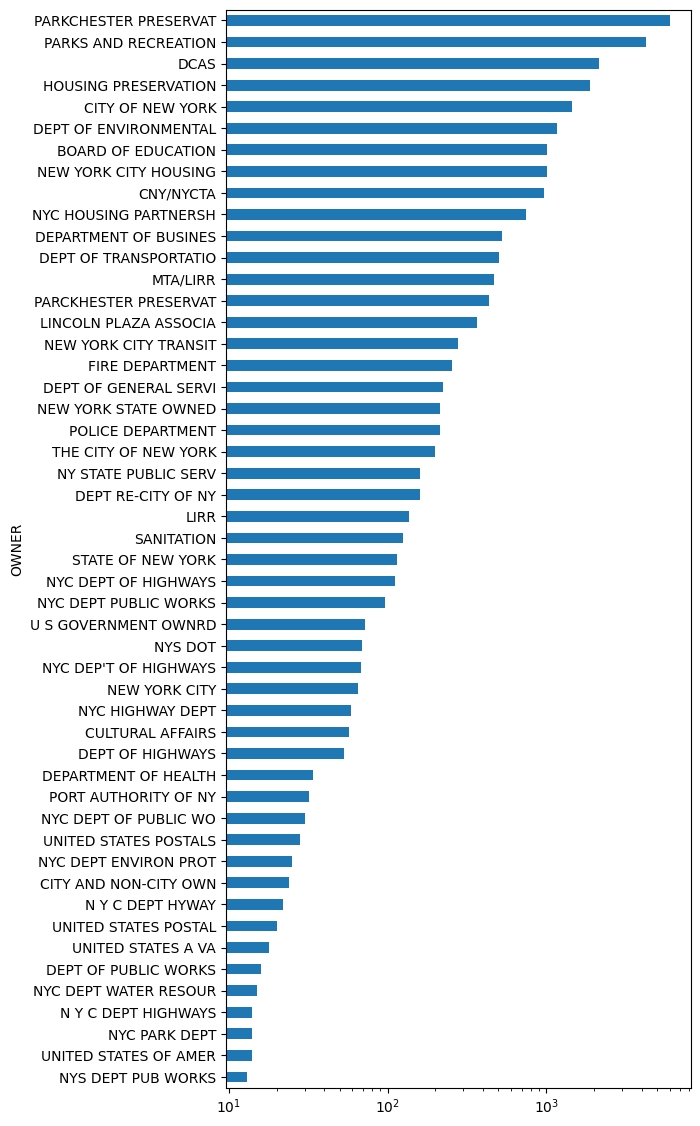

In [18]:
# any on this list that we shouldn't remove?
# plt.rcParams.update({'figure.figsize':(6,14)})
plt.figure(figsize=(6,14))
plt.xscale('log')
removed['OWNER'].value_counts().head(50).sort_values().plot(kind='barh')

In [19]:
data.shape

(1044493, 32)

In [20]:
# this is how many records we removed
numrecords_orig - len(data)

26501

In [21]:
data.head(10)

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,636093.0,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,919276.0,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
2,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,967500.0,5483912.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
3,12,1000041004,1,4,1004,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,163174.0,525692.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
4,13,1000041005,1,4,1005,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,373783.0,1204211.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
5,14,1000041006,1,4,1006,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,353383.0,1138493.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
6,15,1000041007,1,4,1007,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1246572.0,4016063.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
7,16,1000041008,1,4,1008,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1213369.0,3909089.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
8,17,1000041009,1,4,1009,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1213369.0,3909089.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
9,18,1000041010,1,4,1010,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1213369.0,3909089.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR


## Fill in missing ZIP

In [22]:
# How many zips are missing? Replace NAN with 0 and count them.
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
num_missing_zips_orig = len(missing_zips)
num_missing_zips_orig

20431

In [23]:
sum(data['BORO'].isna())

0

In [24]:
sum(data['STADDR'].isna())

364

In [25]:
# concatenate the 'staddr' and 'boro' columns into a new 'staddr_boro' column 
data['staddr_boro'] = data[data['STADDR'].notnull()]['STADDR'] + '_' + data[data['BORO'].notnull()]['BORO'].astype(str)
data['staddr_boro']

0              1 WATER STREET_1
1              1 WATER STREET_1
2              1 WATER STREET_1
3              1 WATER STREET_1
4              1 WATER STREET_1
                   ...         
1044488    142 BENTLEY STREET_5
1044489    146 BENTLEY STREET_5
1044490    150 BENTLEY STREET_5
1044491    156 BENTLEY STREET_5
1044492    162 BENTLEY STREET_5
Name: staddr_boro, Length: 1044493, dtype: object

In [26]:
staddr_boro_zip = {}
for index, staddrboro in data['staddr_boro'].items():
    if staddrboro not in staddr_boro_zip :
        staddr_boro_zip [staddrboro] = data.loc[index, 'ZIP']
        
        
# fill in by mapping with street addrees boroughs
data['ZIP'] = data['ZIP'].fillna(data['staddr_boro'].map(staddr_boro_zip))

In [27]:
# how many mnissing zips did we fill in with this last step?
num_filled_in = num_missing_zips_orig - len(np.where(pd.isnull(data['ZIP']))[0])
num_filled_in

2832

In [28]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

17599

In [29]:
%%time
# Assume the data is already sorted by zip. If a zip is missing, 
# and the before and after zips are the same, fill in the zip with that value
# There should be a more efficient way to calculate this rather than this slow loop...
for i in range(len(missing_zips)):
    if(data.loc[missing_zips[i]+1,'ZIP'] == data.loc[missing_zips[i]-1,'ZIP']):
        data.loc[missing_zips[i],'ZIP'] = data.loc[missing_zips[i]-1,'ZIP']

CPU times: user 874 ms, sys: 16.8 ms, total: 891 ms
Wall time: 893 ms


In [30]:
# how many mnissing zips did we fill in with this last step?
num_filled_in = len(missing_zips) - len(np.where(pd.isnull(data['ZIP']))[0])
num_filled_in

9491

In [31]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

8108

In [32]:
%%time
# For the remaining missing zips, just fill in with the previous record's zip.
# another slow loop that should be improved...
for i in range(len(missing_zips)):
    data.loc[missing_zips[i],'ZIP'] = data.loc[missing_zips[i]-1,'ZIP']

CPU times: user 594 ms, sys: 11.7 ms, total: 605 ms
Wall time: 606 ms


In [33]:
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

0

In [34]:
data = data.drop('staddr_boro', axis=1)

### FULLVAL, AVLAND, AVTOT

#### FULLVAL

In [35]:
len(data[data['FULLVAL']==0])

10025

In [36]:
data['FULLVAL'].isnull().sum()

0

In [37]:
data['FULLVAL'].replace(0, np.nan, inplace=True)
data['FULLVAL'].isnull().sum()

/var/folders/kx/gthdrm8j6mv55clq5hnmrnx40000gn/T/ipykernel_10670/3840300546.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['FULLVAL'].replace(0, np.nan, inplace=True)


10025

In [38]:
data["FULLVAL"] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
data['FULLVAL'].isnull().sum()

7307

In [39]:
data["FULLVAL"] = data.\
                        groupby(['TAXCLASS','BORO'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
data['FULLVAL'].isnull().sum()

386

In [40]:
data["FULLVAL"] = data.\
                        groupby(['TAXCLASS'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
data['FULLVAL'].isnull().sum()

0

#### AVLAND

In [41]:
len(data[data['AVLAND']==0])

10027

In [42]:
data['AVLAND'].isnull().sum()

0

In [43]:
data['AVLAND'].replace(0, np.nan, inplace=True)
data['AVLAND'].isnull().sum()

/var/folders/kx/gthdrm8j6mv55clq5hnmrnx40000gn/T/ipykernel_10670/116382313.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['AVLAND'].replace(0, np.nan, inplace=True)


10027

In [44]:
data["AVLAND"] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
data['AVLAND'].isnull().sum()

7307

In [45]:
data["AVLAND"] = data.\
                        groupby(['TAXCLASS','BORO'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
data['AVLAND'].isnull().sum()

386

In [46]:
data["AVLAND"] = data.\
                        groupby(['TAXCLASS'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
data['AVLAND'].isnull().sum()

0

#### AVTOT

In [47]:
len(data[data['AVTOT']==0])

10025

In [48]:
data['AVTOT'].isnull().sum()

0

In [49]:
data['AVTOT'].replace(0, np.nan, inplace=True)
data['AVTOT'].isnull().sum()

/var/folders/kx/gthdrm8j6mv55clq5hnmrnx40000gn/T/ipykernel_10670/3655551349.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['AVTOT'].replace(0, np.nan, inplace=True)


10025

In [50]:
data["AVTOT"] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
data['AVTOT'].isnull().sum()

7307

In [51]:
data["AVTOT"] = data.\
                        groupby(['TAXCLASS','BORO'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
data['AVTOT'].isnull().sum()

386

In [52]:
data["AVTOT"] = data.\
                        groupby(['TAXCLASS'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
data['AVTOT'].isnull().sum()

0

In [53]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,R5,R5,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,0,0,0,0,0


## Fill in the missing STORIES

In [54]:
data['STORIES'].isnull().sum()

42030

In [55]:
modes = data.groupby(['BORO', 'BLDGCL'])['STORIES'] \
         .transform(lambda x: x.mode(dropna=False).iloc[0])
data['STORIES'] = data['STORIES'].fillna(modes)

In [56]:
data['STORIES'].isnull().sum()

37922

In [57]:
data["STORIES"] = data.\
                        groupby(['TAXCLASS'])['STORIES'].transform(lambda x: x.fillna(x.mean()))

In [58]:
data['STORIES'].isnull().sum()

0

In [59]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,R5,R5,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,0,0,0,0,0


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [60]:
# Because these 4 fields do not have NAs, we just need to replace 0s. 
# We think zero and 1 are invalid values for these fields, so replace them with NA.
# Calculate groupwise average. Replace 0 and 1's by NAs so they are not counted in calculating mean.
# Not sure which values to treat as missing. here are some choices.
data.loc[data['LTFRONT']==0,'LTFRONT']=np.nan
data.loc[data['LTDEPTH']==0,'LTDEPTH']=np.nan
# data.loc[data['BLDFRONT']==0,'BLDFRONT']=np.nan
# data.loc[data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
# data.loc[data['LTFRONT']==1,'LTFRONT']=np.nan
# data.loc[data['LTDEPTH']==1,'LTDEPTH']=np.nan
# data.loc[data['BLDFRONT']==1,'BLDFRONT']=np.nan
# data.loc[data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

In [61]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0,0,636093.0,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0,0,919276.0,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
2,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0,0,967500.0,5483912.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
3,12,1000041004,1,4,1004,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0,0,163174.0,525692.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
4,13,1000041005,1,4,1005,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0,0,373783.0,1204211.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR


#### LTFRONT

In [62]:
data['LTFRONT'].isnull().sum()

160565

In [63]:
data["LTFRONT"] = data.\
                        groupby(['TAXCLASS','BORO'])['LTFRONT'].transform(lambda x: x.fillna(x.mean()))
data[data['LTFRONT'].isnull()]

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
126002,127752,1018259034,1,1825,9034,NaN,NaN,V0,1B,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
126003,127753,1018259036,1,1825,9036,NaN,NaN,V0,1B,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR


In [64]:
data["LTFRONT"] = data.\
                        groupby(['TAXCLASS'])['LTFRONT'].transform(lambda x: x.fillna(x.mean()))
data['LTFRONT'].isnull().sum()

0

#### LTDEPTH

In [65]:
data['LTDEPTH'].isnull().sum()

161656

In [66]:
data["LTDEPTH"] = data.\
                        groupby(['TAXCLASS','BORO'])['LTDEPTH'].transform(lambda x: x.fillna(x.mean()))
data[data['LTDEPTH'].isnull()]

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
126002,127752,1018259034,1,1825,9034,NaN,NaN,V0,1B,45.157933,...,0,0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
126003,127753,1018259036,1,1825,9036,NaN,NaN,V0,1B,45.157933,...,0,0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR


In [67]:
data["LTDEPTH"] = data.\
                        groupby(['TAXCLASS'])['LTDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['LTDEPTH'].isnull().sum()

0

#### BLDFRONT

In [68]:
data['BLDFRONT'].isnull().sum()

0

In [69]:
data['BLDFRONT'] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
data['BLDFRONT'].isnull().sum()

0

In [70]:
data['BLDFRONT'] = data.\
                        groupby(['TAXCLASS','BORO'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
data['BLDFRONT'].isnull().sum()

0

In [71]:
data['BLDFRONT'] = data.\
                        groupby(['TAXCLASS'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
data['BLDFRONT'].isnull().sum()

0

#### BLDEPTH

In [72]:
data['BLDDEPTH'].isnull().sum()

0

In [73]:
data['BLDDEPTH'] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['BLDDEPTH'].isnull().sum()

0

In [74]:
data['BLDDEPTH'] = data.\
                        groupby(['TAXCLASS','BORO'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['BLDDEPTH'].isnull().sum()

0

In [75]:
data['BLDDEPTH'] = data.\
                        groupby(['TAXCLASS'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['BLDDEPTH'].isnull().sum()

0

In [76]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [77]:
# convert ZIP to a string rather than a float
# We call the first three digits of the zip zip3
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [78]:
data.count()

RECORD      1044493
BBLE        1044493
BORO        1044493
BLOCK       1044493
LOT         1044493
EASEMENT       1976
OWNER       1012749
BLDGCL      1044493
TAXCLASS    1044493
LTFRONT     1044493
LTDEPTH     1044493
EXT          353646
STORIES     1044493
FULLVAL     1044493
AVLAND      1044493
AVTOT       1044493
EXLAND      1044493
EXTOT       1044493
EXCD1        623529
STADDR      1044129
ZIP         1044493
EXMPTCL        9296
BLDFRONT    1044493
BLDDEPTH    1044493
AVLAND2      266066
AVTOT2       266072
EXLAND2       80845
EXTOT2       117834
EXCD2         92904
PERIOD      1044493
YEAR        1044493
VALTYPE     1044493
zip3        1044493
dtype: int64

In [79]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')


### Now build variables that try to find properties that are unusual in ways we're interested in

In [80]:
# epsilon is an arbitrary small number to make sure we don't divide by zero
epsilon = .0001
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH'] + epsilon
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH'] + epsilon
data['bldvol'] = data['bldsize'] * data['STORIES'] + epsilon

In [81]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [82]:
data.describe()

,RECORD,BORO,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,...,bldvol,r1,r2,r3,r4,r5,r6,r7,r8,r9
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,...,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,5.368069e+05,3.220281e+00,4.756777e+03,3.509013e+02,5.038952e+01,1.073730e+02,4.969850e+00,8.166002e+05,6.654802e+04,1.999379e+05,...,1.882668e+04,2.131696e+02,8.716940e+08,1.029793e+08,1.015699e+01,1.240345e+08,1.631564e+07,2.563845e+01,3.780089e+08,4.185262e+07
std,3.080025e+05,1.199074e+00,3.677416e+03,8.267095e+02,5.998346e+01,5.153903e+01,8.225039e+00,6.399805e+06,2.012308e+06,5.392440e+06,...,2.320268e+06,1.075806e+03,2.926562e+10,3.401376e+09,1.027257e+02,1.796439e+10,4.403906e+09,1.853214e+02,4.748039e+10,1.150911e+10
min,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,...,2.000000e-04,3.623988e-04,4.167249e-03,1.344274e-04,8.333333e-06,3.217901e-04,1.038033e-05,8.333333e-06,1.875268e-03,6.049251e-05
25%,2.729100e+05,3.000000e+00,1.542000e+03,2.300000e+01,2.100000e+01,1.000000e+02,2.000000e+00,3.181550e+05,9.679000e+03,1.892600e+04,...,9.880003e+02,7.587719e+01,4.587170e+02,2.176576e+02,2.376800e+00,1.355052e+01,6.487252e+00,5.388272e+00,2.450765e+01,1.168112e+01
50%,5.387720e+05,3.000000e+00,4.078000e+03,4.900000e+01,3.000000e+01,1.000000e+02,2.000000e+00,4.540000e+05,1.387800e+04,2.579100e+04,...,1.548000e+03,1.534691e+02,6.365131e+02,3.103174e+02,4.592648e+00,1.884615e+01,9.274998e+00,8.628333e+00,3.302333e+01,1.613350e+01
75%,8.022750e+05,4.000000e+00,6.920000e+03,1.400000e+02,6.000000e+01,1.120000e+02,4.000000e+00,6.240000e+05,1.998000e+04,4.724400e+04,...,2.520000e+03,2.430107e+02,1.073949e+03,5.111110e+02,7.219375e+00,3.456490e+01,1.705263e+01,1.354054e+01,1.078772e+02,4.296200e+01
max,1.070994e+06,5.000000e+00,1.635000e+04,9.450000e+03,9.999000e+03,9.619000e+03,1.190000e+02,1.663775e+09,1.792809e+09,4.668309e+09,...,2.205711e+09,8.359164e+05,1.663775e+13,2.376821e+12,6.364894e+04,1.792809e+13,4.482022e+12,7.055341e+04,4.668309e+13,1.167077e+13


I want outliers in these 9 variables, either very high or very low. Very high is easy to find but very low might be close to
zero and probably not many standard deviations below the average. A simple way to look for outliers that are very low is to also include 1/over these variables, which will be very large outliers when the variables are very low.
First I scale them all to have reasonable average.

In [83]:
vars9 = ['r1','r2','r3','r4','r5','r6','r7','r8','r9']
for vars in vars9:
    data[vars] = data[vars]/data[vars].median()
    
data.describe()

,RECORD,BORO,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,...,bldvol,r1,r2,r3,r4,r5,r6,r7,r8,r9
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,...,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,5.368069e+05,3.220281e+00,4.756777e+03,3.509013e+02,5.038952e+01,1.073730e+02,4.969850e+00,8.166002e+05,6.654802e+04,1.999379e+05,...,1.882668e+04,1.389007e+00,1.369483e+06,3.318515e+05,2.211576e+00,6.581424e+06,1.759099e+06,2.971426e+00,1.144672e+07,2.594144e+06
std,3.080025e+05,1.199074e+00,3.677416e+03,8.267095e+02,5.998346e+01,5.153903e+01,8.225039e+00,6.399805e+06,2.012308e+06,5.392440e+06,...,2.320268e+06,7.009922e+00,4.597804e+07,1.096096e+07,2.236742e+01,9.532127e+08,4.748148e+08,2.147824e+01,1.437783e+09,7.133672e+08
min,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,...,2.000000e-04,2.361380e-06,6.546997e-06,4.331932e-07,1.814494e-06,1.707458e-05,1.119173e-06,9.658104e-07,5.678615e-05,3.749497e-06
25%,2.729100e+05,3.000000e+00,1.542000e+03,2.300000e+01,2.100000e+01,1.000000e+02,2.000000e+00,3.181550e+05,9.679000e+03,1.892600e+04,...,9.880003e+02,4.944136e-01,7.206718e-01,7.014033e-01,5.175228e-01,7.190075e-01,6.994344e-01,6.244859e-01,7.421314e-01,7.240288e-01
50%,5.387720e+05,3.000000e+00,4.078000e+03,4.900000e+01,3.000000e+01,1.000000e+02,2.000000e+00,4.540000e+05,1.387800e+04,2.579100e+04,...,1.548000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,8.022750e+05,4.000000e+00,6.920000e+03,1.400000e+02,6.000000e+01,1.120000e+02,4.000000e+00,6.240000e+05,1.998000e+04,4.724400e+04,...,2.520000e+03,1.583451e+00,1.687239e+00,1.647059e+00,1.571942e+00,1.834056e+00,1.838559e+00,1.569311e+00,3.266698e+00,2.662906e+00
max,1.070994e+06,5.000000e+00,1.635000e+04,9.450000e+03,9.999000e+03,9.619000e+03,1.190000e+02,1.663775e+09,1.792809e+09,4.668309e+09,...,2.205711e+09,5.446807e+03,2.613890e+10,7.659324e+09,1.385888e+04,9.512865e+11,4.832370e+11,8.176945e+03,1.413640e+12,7.233875e+11


In [84]:
# add in the inverse of all the 9 primary variables.
for vars in vars9:
    data[vars+'inv'] = 1/(data[vars] + epsilon)

In [85]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,r9,r1inv,r2inv,r3inv,r4inv,r5inv,r6inv,r7inv,r8inv,r9inv
0,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,70.764312,...,2.157419e+07,0.319308,1.613565e-08,4.011950e-07,0.059260,2.962798e-09,7.436411e-08,0.039895,1.860319e-09,4.635167e-08
1,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,70.764312,...,3.117881e+07,0.220947,1.116507e-08,2.776071e-07,0.041005,2.050108e-09,5.145624e-08,0.027605,1.287249e-09,3.207306e-08
2,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,70.764312,...,5.797218e+07,0.118832,6.004840e-09,1.493036e-07,0.038961,1.947923e-09,4.889146e-08,0.014847,6.923130e-10,1.724965e-08
3,12,1000041004,1,4,1004,NaN,"TRZ HOLDINGS, LLC",R5,4,70.764312,...,5.534314e+06,1.244631,6.290102e-08,1.563964e-06,0.231007,1.154973e-08,2.898899e-07,0.155518,7.252009e-09,1.806909e-07
4,13,1000041005,1,4,1005,NaN,"TRZ HOLDINGS, LLC",R5,4,70.764312,...,1.267746e+07,0.543378,2.745927e-08,6.827441e-07,0.100847,5.042003e-09,1.265507e-07,0.067892,3.165847e-09,7.888016e-08


Now I want the large outliers where the variables are either very low or very high, so I'll keep only one of the two, r or rinv, depending on which is largest. This allows me to find both the very low and high outliers.

In [86]:
for vars in vars9:
    data[vars] = data[[vars,vars+'inv']].max(axis=1)

Now I can remove the inverse columns since I have the 9 variables that I need

In [87]:
for vars in vars9:
    data.drop(columns=(vars+'inv'),inplace=True)

data.describe()

,RECORD,BORO,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,...,bldvol,r1,r2,r3,r4,r5,r6,r7,r8,r9
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,...,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,5.368069e+05,3.220281e+00,4.756777e+03,3.509013e+02,5.038952e+01,1.073730e+02,4.969850e+00,8.166002e+05,6.654802e+04,1.999379e+05,...,1.882668e+04,1.278718e+01,1.369487e+06,3.318714e+05,8.438390e+00,6.581427e+06,1.759112e+06,5.619203e+00,1.144672e+07,2.594148e+06
std,3.080025e+05,1.199074e+00,3.677416e+03,8.267095e+02,5.998346e+01,5.153903e+01,8.225039e+00,6.399805e+06,2.012308e+06,5.392440e+06,...,2.320268e+06,1.071679e+02,4.597804e+07,1.096096e+07,7.633238e+01,9.532127e+08,4.748148e+08,4.930640e+01,1.437783e+09,7.133672e+08
min,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,...,2.000000e-04,9.999509e-01,9.999527e-01,9.999536e-01,9.999509e-01,9.999502e-01,9.999501e-01,9.999506e-01,9.999518e-01,9.999519e-01
25%,2.729100e+05,3.000000e+00,1.542000e+03,2.300000e+01,2.100000e+01,1.000000e+02,2.000000e+00,3.181550e+05,9.679000e+03,1.892600e+04,...,9.880003e+02,1.269311e+00,1.175710e+00,1.193386e+00,1.262819e+00,1.164235e+00,1.190051e+00,1.233185e+00,1.167401e+00,1.193678e+00
50%,5.387720e+05,3.000000e+00,4.078000e+03,4.900000e+01,3.000000e+01,1.000000e+02,2.000000e+00,4.540000e+05,1.387800e+04,2.579100e+04,...,1.548000e+03,1.700668e+00,1.464065e+00,1.492779e+00,1.681746e+00,1.461403e+00,1.524989e+00,1.585474e+00,1.468400e+00,1.502895e+00
75%,8.022750e+05,4.000000e+00,6.920000e+03,1.400000e+02,6.000000e+01,1.120000e+02,4.000000e+00,6.240000e+05,1.998000e+04,4.724400e+04,...,2.520000e+03,3.203315e+00,5.346292e+00,5.832737e+00,3.255309e+00,7.959887e+00,9.422823e+00,2.709551e+00,4.899222e+00,4.634348e+00
max,1.070994e+06,5.000000e+00,1.635000e+04,9.450000e+03,9.999000e+03,9.619000e+03,1.190000e+02,1.663775e+09,1.792809e+09,4.668309e+09,...,2.205711e+09,9.769309e+03,2.613890e+10,7.659324e+09,1.385888e+04,9.512865e+11,4.832370e+11,9.904343e+03,1.413640e+12,7.233875e+11


In [88]:
# Standardized variables by appropriate logical group
zip5_mean = data.groupby('ZIP')[vars9].mean()
taxclass_mean = data.groupby('TAXCLASS')[vars9].mean()
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
rsuffix = ['_zip5', '_taxclass']
for var in vars9:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [89]:
# include two more possibly interesting variables
data['value_ratio'] = data['FULLVAL']/(data['AVLAND']+data['AVTOT'])
data['value_ratio'] = data['value_ratio']/data['value_ratio'].mean()
# again, use 1/variable if that's larger, in order to find the low outliers
data['value_ratio'] = np.where(data['value_ratio'] < 1, 1/(data['value_ratio']+epsilon), data['value_ratio'])
data['size_ratio'] = data['bldsize'] / (data['ltsize']+1)

In [90]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
...,...,...,...,...,...
r7_taxclass,1.28701,1.859975,3.458335,0.33015,0.756275
r8_taxclass,7.167239,10.358023,19.259143,1.838574,4.211623
r9_taxclass,1.120785,1.619747,3.01167,0.287509,0.658597
value_ratio,8.056705,8.056707,7.135024,8.056717,8.056713


In [91]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3', 'ltsize', 'bldsize',
       'bldvol', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
       'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1_taxclass', 'r2_taxclass',
       'r3_taxclass', 'r4_taxclass', 'r5_taxclass', 'r6_taxclass',
       'r7_taxclass', 'r8_taxclass', 'r9_taxclass', 'value_ratio',
       'size_ratio'],
      dtype='object')

In [92]:
save_record = data['RECORD']
save_record.head()

0     9
1    10
2    11
3    12
4    13
Name: RECORD, dtype: int64

In [93]:
dropcols = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
data = data.drop(columns = dropcols)
data.shape

(1044493, 29)

In [94]:
# this dataframe is now just the variables for our unsupervised fraud models
data.head().transpose()

,0,1,2,3,4
r1,3.131675e+00,4.525864e+00,8.415147e+00,1.244631e+00,1.840239e+00
r2,6.197457e+07,8.956501e+07,1.665323e+08,1.589799e+07,3.641757e+07
r3,2.492554e+06,3.602213e+06,6.697760e+06,6.394010e+05,1.464678e+06
r4,1.687463e+01,2.438706e+01,2.566638e+01,4.328770e+00,9.915923e+00
r5,3.375188e+08,4.877792e+08,5.133674e+08,8.658213e+07,1.983339e+08
r6,1.344735e+07,1.943399e+07,2.045347e+07,3.449586e+06,7.901973e+06
r7,2.506589e+01,3.622498e+01,6.735474e+01,6.430020e+00,1.472925e+01
r8,5.375421e+08,7.768505e+08,1.444433e+09,1.378928e+08,3.158713e+08
r9,2.157419e+07,3.117881e+07,5.797218e+07,5.534314e+06,1.267746e+07
r1_zip5,3.448350e-01,4.983520e-01,9.266087e-01,1.370488e-01,2.026324e-01


In [95]:
# Calculate and write the basic statistics of all the variables to check if everything looks OK
stats = data.describe().transpose()
# stats.to_excel('stats_on_vars.xlsx')
stats

,count,mean,std,min,25%,50%,75%,max
r1,1044493.0,1.278718e+01,1.071679e+02,9.999509e-01,1.269311e+00,1.700668,3.203315,9.769309e+03
r2,1044493.0,1.369487e+06,4.597804e+07,9.999527e-01,1.175710e+00,1.464065,5.346292,2.613890e+10
r3,1044493.0,3.318714e+05,1.096096e+07,9.999536e-01,1.193386e+00,1.492779,5.832737,7.659324e+09
r4,1044493.0,8.438390e+00,7.633238e+01,9.999509e-01,1.262819e+00,1.681746,3.255309,1.385888e+04
r5,1044493.0,6.581427e+06,9.532127e+08,9.999502e-01,1.164235e+00,1.461403,7.959887,9.512865e+11
r6,1044493.0,1.759112e+06,4.748148e+08,9.999501e-01,1.190051e+00,1.524989,9.422823,4.832370e+11
r7,1044493.0,5.619203e+00,4.930640e+01,9.999506e-01,1.233185e+00,1.585474,2.709551,9.904343e+03
r8,1044493.0,1.144672e+07,1.437783e+09,9.999518e-01,1.167401e+00,1.468400,4.899222,1.413640e+12
r9,1044493.0,2.594148e+06,7.133672e+08,9.999519e-01,1.193678e+00,1.502895,4.634348,7.233875e+11
r1_zip5,1044493.0,1.000000e+00,7.969183e+00,5.041962e-03,1.661598e-01,0.327453,0.676592,2.287733e+03


In [96]:
# data.to_csv('NY vars.csv', index=False)

In [97]:
data.isna().sum().sum()

0

In [98]:
# zscale all the variables
data_zs = (data - data.mean()) / data.std()
data_zs_save = data_zs.copy()
data_zs.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
r1,1044493.0,-3.555118e-17,1.0,-0.109988,-0.107475,-0.103450,-0.089429,91.039631
r2,1044493.0,7.523844e-18,1.0,-0.029786,-0.029786,-0.029786,-0.029786,568.478537
r3,1044493.0,-1.415313e-17,1.0,-0.030278,-0.030277,-0.030277,-0.030277,698.752039
r4,1044493.0,-8.707523e-18,1.0,-0.097448,-0.094004,-0.088516,-0.067901,181.449075
r5,1044493.0,-3.039130e-18,1.0,-0.006904,-0.006904,-0.006904,-0.006904,997.972287
r6,1044493.0,-7.874186e-19,1.0,-0.003705,-0.003705,-0.003705,-0.003705,1017.734254
r7,1044493.0,-5.610910e-17,1.0,-0.093685,-0.088954,-0.081809,-0.059012,200.759399
r8,1044493.0,4.027229e-18,1.0,-0.007961,-0.007961,-0.007961,-0.007961,983.199735
r9,1044493.0,1.098645e-18,1.0,-0.003636,-0.003636,-0.003636,-0.003636,1014.042956
r1_zip5,1044493.0,-2.729264e-17,1.0,-0.124851,-0.104633,-0.084393,-0.040582,286.946963


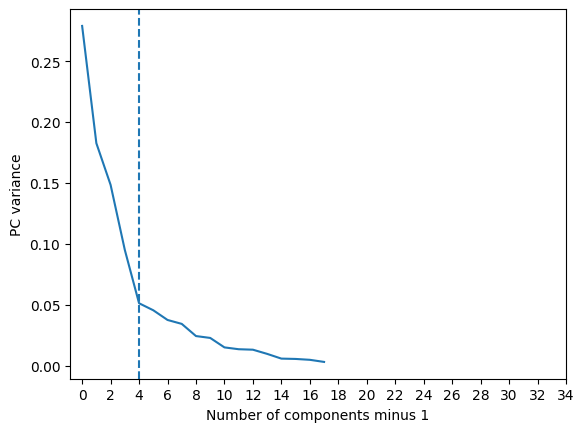

In [99]:
# do a complete PCA and look at the scree and cumulative variance plots
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')

(0.0, 1.0)

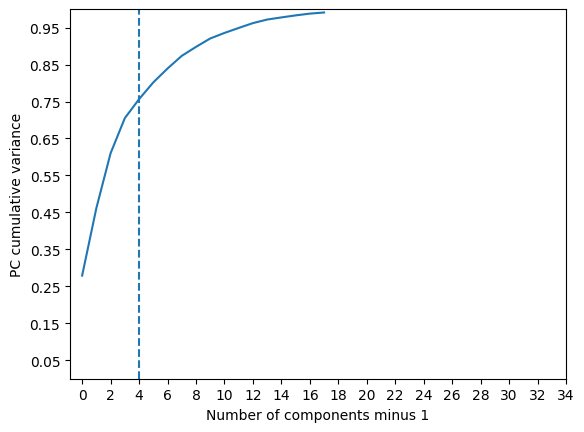

In [100]:
plt.xlabel('Number of components minus 1')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('PC cumulative variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')
plt.ylim(0,1)

In [101]:
%%time
# now redo the PCA but just keep the top few PCs
data_zs = data_zs_save.copy()
pca = PCA(n_components = 5, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

CPU times: user 6.72 s, sys: 1.15 s, total: 7.87 s
Wall time: 1.58 s


5

In [102]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.27895806 0.46160261 0.61006368 0.70507372 0.75630657]


In [103]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1044493, 5)

In [104]:
data_pca.head(5)

,PC1,PC2,PC3,PC4,PC5
0,0.626218,0.082586,0.075630,0.127271,-0.353079
1,0.961034,0.298577,0.115173,0.164290,-0.430701
2,1.666448,0.732373,0.251966,0.155294,-0.638007
3,0.067224,-0.274550,0.009383,0.065440,-0.224412
4,0.316078,-0.117486,0.039001,0.092982,-0.281177


In [105]:
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,-1.659872e-18,8.598679e-18,-5.646285e-18,7.108876e-18,9.687120e-18
std,2.844255e+00,2.301454e+00,2.074939e+00,1.659907e+00,1.218915e+00
min,-1.392586e-01,-1.219300e+02,-6.098745e+02,-5.803034e+02,-2.742806e+02
25%,-1.211777e-01,-2.467542e-01,-3.691250e-02,4.487944e-02,-1.202138e-01
50%,-1.173136e-01,-1.979604e-01,-3.313189e-02,5.051121e-02,6.603108e-02
75%,-9.742683e-02,-1.164504e-01,-2.896227e-02,5.092003e-02,1.108852e-01
max,2.055377e+03,8.274440e+02,9.060543e+02,1.112732e+03,6.630523e+02


In [106]:
# zscale the pcs.
# I do this (make all the retained PCs equally important) if I only keep a small number of PCs.
# Alternatively you can keep maybe up to 6 to 8 or so, and don't do this second z scale
# I prefer to keep a somewhat small number of PCs and then make them all equally important via zscaling.
# This second zscale step makes the later Minkowski distance to be similar to a Mahalanobis distance.
# Many people don't do this second zscaling, but I like to do it.

data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()

,PC1,PC2,PC3,PC4,PC5
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,-9.013647e-19,4.734716e-18,3.945596e-19,6.700711e-19,8.707523e-19
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.896135e-02,-5.297953e+01,-2.939241e+02,-3.496000e+02,-2.250203e+02
25%,-4.260437e-02,-1.072167e-01,-1.778968e-02,2.703733e-02,-9.862364e-02
50%,-4.124582e-02,-8.601536e-02,-1.596765e-02,3.043015e-02,5.417203e-02
75%,-3.425391e-02,-5.059860e-02,-1.395813e-02,3.067643e-02,9.097047e-02
max,7.226418e+02,3.595309e+02,4.366655e+02,6.703578e+02,5.439694e+02


In [107]:
data_pca_zs.shape

(1044493, 5)

In [108]:
data_pca_zs.head(5)

,PC1,PC2,PC3,PC4,PC5
0,0.220169,0.035884,0.036449,0.076674,-0.289667
1,0.337886,0.129734,0.055507,0.098975,-0.353348
2,0.585900,0.318222,0.121433,0.093556,-0.523422
3,0.023635,-0.119294,0.004522,0.039424,-0.184108
4,0.111129,-0.051049,0.018796,0.056016,-0.230679


## Now calculate two unsupervised fraud scores

In [109]:
# Set the powers for the two Minkowski distances. The final results are relatively insensitive to these choices. 
# Good choices are anywhere from 1 to about 4.
p1 = 2
p2 = 2
ntop = 10000

### Calculate score 1

In [110]:
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1
score1.head(10)

0    0.375335
1    0.518392
2    0.861402
3    0.224188
4    0.267693
5    0.261266
6    0.696578
7    0.678159
8    0.678159
9    0.678159
dtype: float64

In [111]:
data_pca_zs.head(10)

,PC1,PC2,PC3,PC4,PC5
0,0.220169,0.035884,0.036449,0.076674,-0.289667
1,0.337886,0.129734,0.055507,0.098975,-0.353348
2,0.585900,0.318222,0.121433,0.093556,-0.523422
3,0.023635,-0.119294,0.004522,0.039424,-0.184108
4,0.111129,-0.051049,0.018796,0.056016,-0.230679
5,0.102649,-0.057809,0.017424,0.054410,-0.226091
6,0.473941,0.238204,0.077533,0.124751,-0.426950
7,0.460138,0.227200,0.075299,0.122136,-0.419483
8,0.460138,0.227200,0.075299,0.122136,-0.419483
9,0.460138,0.227200,0.075299,0.122136,-0.419483


In [112]:
score1.max()

1002.9115959404011

### Autoencoder for score 2

In [113]:
%%time
# you don't need the autoencoder to be really good, just a little bit trained so it can find the really unusual records
# you can set max_iter to 100 and it takes about a minute, or 500 and it takes about 7 minutes. But even 50 is good enough.
NNmodel = MLPRegressor(hidden_layer_sizes=(3),activation='logistic',max_iter=50,random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)

CPU times: user 26.8 s, sys: 420 ms, total: 27.3 s
Wall time: 27.8 s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', hidden_layer_sizes=3, max_iter=50,
             random_state=1)

In [114]:
# calculate score 2 as the error of an autoencoder
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2

In [115]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['RECORD'] = save_record
scores.head(10)

,score1,score2,RECORD
0,0.375335,0.288650,9
1,0.518392,0.383955,10
2,0.861402,0.578974,11
3,0.224188,0.164549,12
4,0.267693,0.210106,13
5,0.261266,0.204746,14
6,0.696578,0.499254,15
7,0.678159,0.487424,16
8,0.678159,0.487424,17
9,0.678159,0.487424,18


In [116]:
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank
0,0.375335,0.288650,9,963422.0,996754.0
1,0.518392,0.383955,10,986676.0,1010910.0
2,0.861402,0.578974,11,1008744.0,1023237.0
3,0.224188,0.164549,12,859247.0,899252.0
4,0.267693,0.210106,13,913952.0,959211.0
5,0.261266,0.204746,14,907771.0,954153.0
6,0.696578,0.499254,15,1000745.0,1019686.0
7,0.678159,0.487424,16,999686.0,1018993.0
8,0.678159,0.487424,17,999681.0,1018990.0
9,0.678159,0.487424,18,999680.0,1018988.0


In [117]:
# calculate the final score as the average of the two scores
# you could do other possible combinations of these if you want
# You could do different weightings, or a max or min
weight = .5
scores['final'] = (weight*scores['score1 rank'] + (1-weight)*scores['score2 rank'])
scores_sorted = scores.sort_values(by='final', ascending=False)
scores_sorted.head(20)

,score1,score2,RECORD,score1 rank,score2 rank,final
897398,1002.911596,1001.832572,917942,1044493.0,1044493.0,1044493.0
1040913,652.745860,626.935489,1067360,1044492.0,1044492.0,1044492.0
544656,611.962465,585.758544,561383,1044491.0,1044491.0,1044491.0
1028918,484.639516,454.903969,1053832,1044490.0,1044490.0,1044490.0
383034,384.075180,354.741454,398266,1044489.0,1044489.0,1044489.0
676143,321.587032,292.923182,694272,1044488.0,1044488.0,1044488.0
383045,293.379125,264.206616,398284,1044487.0,1044487.0,1044487.0
632014,286.152286,248.559131,649717,1044486.0,1044486.0,1044486.0
29547,275.354790,246.406055,30042,1044485.0,1044485.0,1044485.0
281415,270.803421,245.134914,293330,1044484.0,1044484.0,1044484.0


In [118]:
scores_sorted.tail(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
561013,0.015249,0.008273,577863,30.0,55.0,42.5
560943,0.017287,0.007502,577793,56.0,25.0,40.5
560995,0.015230,0.008206,577845,26.0,51.0,38.5
561000,0.015912,0.007507,577850,42.0,26.0,34.0
560982,0.015519,0.007634,577832,35.0,29.0,32.0
567963,0.015142,0.008005,584985,23.0,40.0,31.5
560969,0.016717,0.007458,577819,50.0,9.0,29.5
561666,0.014153,0.007700,578530,11.5,30.5,21.0
561645,0.014153,0.007700,578509,11.5,30.5,21.0
567953,0.014470,0.007423,584975,14.0,8.0,11.0


In [119]:
scores.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,2.859545e-01,1.391804e-01,5.368069e+05,5.222470e+05,5.222470e+05,5.222470e+05
std,2.217708e+00,1.837255e+00,3.080025e+05,3.015193e+05,3.015193e+05,2.888556e+05
min,1.320407e-02,6.565164e-03,9.000000e+00,1.000000e+00,1.000000e+00,1.100000e+01
25%,1.264480e-01,4.056144e-02,2.729100e+05,2.611235e+05,2.611240e+05,2.956300e+05
50%,1.480104e-01,6.235986e-02,5.387720e+05,5.222470e+05,5.222475e+05,4.916095e+05
75%,1.914463e-01,1.207303e-01,8.022750e+05,7.833715e+05,7.833700e+05,7.791110e+05
max,1.002912e+03,1.001833e+03,1.070994e+06,1.044493e+06,1.044493e+06,1.044493e+06


In [120]:
scores_sorted.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,2.859545e-01,1.391804e-01,5.368069e+05,5.222470e+05,5.222470e+05,5.222470e+05
std,2.217708e+00,1.837255e+00,3.080025e+05,3.015193e+05,3.015193e+05,2.888556e+05
min,1.320407e-02,6.565164e-03,9.000000e+00,1.000000e+00,1.000000e+00,1.100000e+01
25%,1.264480e-01,4.056144e-02,2.729100e+05,2.611235e+05,2.611240e+05,2.956300e+05
50%,1.480104e-01,6.235986e-02,5.387720e+05,5.222470e+05,5.222475e+05,4.916095e+05
75%,1.914463e-01,1.207303e-01,8.022750e+05,7.833715e+05,7.833700e+05,7.791110e+05
max,1.002912e+03,1.001833e+03,1.070994e+06,1.044493e+06,1.044493e+06,1.044493e+06


In [121]:
scores_sorted.set_index('RECORD', drop=True, inplace=True)
scores_sorted.head(10)

,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,
917942,1002.911596,1001.832572,1044493.0,1044493.0,1044493.0
1067360,652.745860,626.935489,1044492.0,1044492.0,1044492.0
561383,611.962465,585.758544,1044491.0,1044491.0,1044491.0
1053832,484.639516,454.903969,1044490.0,1044490.0,1044490.0
398266,384.075180,354.741454,1044489.0,1044489.0,1044489.0
694272,321.587032,292.923182,1044488.0,1044488.0,1044488.0
398284,293.379125,264.206616,1044487.0,1044487.0,1044487.0
649717,286.152286,248.559131,1044486.0,1044486.0,1044486.0
30042,275.354790,246.406055,1044485.0,1044485.0,1044485.0


(0.1, 2084791.0382850934)

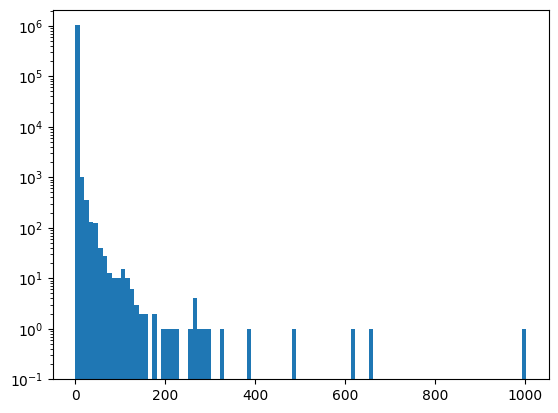

In [122]:
sc1max = int(score1.max())
plt.hist(score1, bins =100, range=(0,sc1max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

In [123]:
sc2max = int(score2.max())
sc2max

1001

1001


(0.1, 2087081.5533143904)

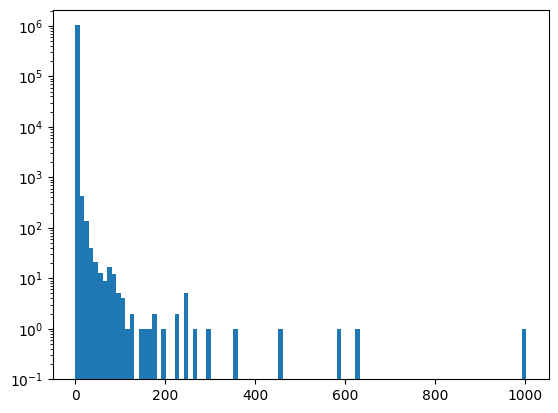

In [124]:
sc2max = int(score2.max())
print(sc2max)
plt.hist(score2, bins =100, range=(0,sc2max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

The flatter the next plot, the more similar are the two scores. 
If the two scores are very similar then the rank order hardly changes and the plot is flat.

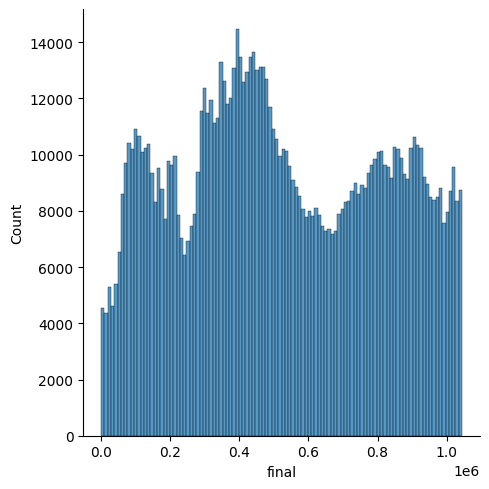

In [125]:
sns.displot(scores['final'])

In [126]:
top_records = scores_sorted.head(ntop).index
print(top_records)

Index([ 917942, 1067360,  561383, 1053832,  398266,  694272,  398284,  649717,
         30042,  293330,
       ...
        664532,  664520,  664521,  664518, 1003626,   17651,   35056,   51203,
         35104,  113243],
      dtype='int64', name='RECORD', length=10000)


In [127]:
data_zs['RECORD'] = save_record
data_zs.set_index('RECORD', inplace=True, drop=True)
data_zs.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
9,-0.090097,1.318131,0.197125,0.110520,0.347181,0.024616,0.394405,0.365907,0.026606,-0.082212,...,0.138571,0.015399,-0.080332,0.114757,-0.001844,0.049472,0.114450,0.002113,0.263333,-0.029621
10,-0.077088,1.918210,0.298363,0.208937,0.504817,0.037225,0.620726,0.532350,0.040070,-0.062948,...,0.208133,0.030825,-0.037413,0.174891,0.005920,0.148234,0.173663,0.010843,0.263333,-0.029621
11,-0.040796,3.592211,0.580778,0.225697,0.531661,0.039372,1.252080,0.996664,0.077629,-0.009209,...,0.402185,0.073859,-0.030104,0.185131,0.007242,0.423744,0.338847,0.035195,0.212785,-0.029621
12,-0.107705,0.315988,0.028057,-0.053838,0.083927,0.003560,0.016444,0.087945,0.004122,-0.108286,...,0.022401,-0.010364,-0.152008,0.014333,-0.014809,-0.115462,0.015562,-0.012465,0.263334,-0.029621
13,-0.102148,0.762279,0.103349,0.019357,0.201164,0.012937,0.184764,0.211732,0.014135,-0.100056,...,0.074136,0.001109,-0.120088,0.059056,-0.009035,-0.042011,0.059600,-0.005973,0.263334,-0.029621


In [128]:
scores.set_index('RECORD',inplace=True)
scores.drop(columns=['score1','score2'],inplace=True)
scores.head(30)

,score1 rank,score2 rank,final
RECORD,,,
9,963422.0,996754.0,980088.0
10,986676.0,1010910.0,998793.0
11,1008744.0,1023237.0,1015990.5
12,859247.0,899252.0,879249.5
13,913952.0,959211.0,936581.5
14,907771.0,954153.0,930962.0
15,1000745.0,1019686.0,1010215.5
16,999686.0,1018993.0,1009339.5
17,999681.0,1018990.0,1009335.5


In [129]:
scores.tail(30)

,score1 rank,score2 rank,final
RECORD,,,
1070965,746167.0,738416.0,742291.5
1070966,787716.0,798866.0,793291.0
1070967,952542.0,985436.0,968989.0
1070968,976575.0,1005365.0,990970.0
1070969,954100.0,987022.0,970561.0
1070970,906289.0,934856.0,920572.5
1070971,947722.0,980537.0,964129.5
1070972,650461.0,604523.0,627492.0
1070973,917386.0,947703.0,932544.5


In [130]:
NY_data_with_scores = NY_data_orig.join(scores, on='RECORD')
NY_data_with_scores['final'].fillna(1,inplace=True)
NY_data_with_scores

/var/folders/kx/gthdrm8j6mv55clq5hnmrnx40000gn/T/ipykernel_10670/3385311105.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  NY_data_with_scores['final'].fillna(1,inplace=True)


,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070989,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,824201.0,844799.0,834500.0
1070990,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,991655.0,1015031.0,1003343.0
1070991,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53,...,NaN,NaN,NaN,1017.0,FINAL,2010/11,AC-TR,974315.0,1003947.0,989131.0
1070992,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,805653.0,822188.0,813920.5


In [131]:
NY_data_scored_and_sorted = NY_data_with_scores.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_scored_zs = NY_data_with_scores.join(data_zs, on='RECORD')
NY_data_scored_zs.set_index('RECORD',inplace=True)
NY_data_scored_zs.head(20)

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,1260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1000030002,1,3,2,NaN,PARKS AND RECREATION,Q1,4,496,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1000030003,1,3,3,NaN,PARKS AND RECREATION,Q1,4,180,370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1000030010,1,3,10,NaN,DEPT RE-CITY OF NY,Z9,4,362,177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,0,...,0.138571,0.015399,-0.080332,0.114757,-0.001844,0.049472,0.114450,0.002113,0.263333,-0.029621


In [132]:
NY_data_scored_zs_sorted = NY_data_scored_zs.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_top_n = NY_data_scored_zs_sorted.head(ntop)
NY_data_top_n

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,...,14.797252,41.869926,3.455744,380.681061,626.655532,7.626936,349.766521,657.466678,12.040692,-0.029621
1067360,5078530085,5,7853,85,NaN,NaN,B2,1,1,1,...,-0.017679,-0.019249,659.145627,-0.020313,-0.019278,604.232180,-0.018554,-0.017490,-0.110205,66.092759
561383,3084700055,3,8470,55,NaN,YILDIZ HOLDING A.S.,K6,4,930,650,...,10.201703,38.507784,-0.093211,8.598934,18.898316,0.024632,8.680534,21.784521,0.260498,-0.029621
1053832,5064310001,5,6431,1,NaN,"MARKOW, REGINA",A3,1,615,1054,...,643.123297,665.604588,1.733939,275.649705,255.360493,3.197569,198.863332,188.477643,0.073000,-0.029621
398266,3044520090,3,4452,90,NaN,"STARRETT CITY, INC.",Z0,1,907,201,...,342.145992,341.501570,0.213626,380.013774,339.512253,0.481490,289.020332,264.175803,-0.084083,-0.029621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17651,1003490028,1,349,28,NaN,"67 CLINTON STREET, LL",S2,1,20,50,...,-0.017665,-0.019244,0.911962,-0.020308,-0.019278,0.782048,-0.018548,-0.017489,-0.010258,0.051935
35056,1007190012,1,719,12,NaN,"ARSLANIAN, CORINE",A4,1,16,98,...,-0.017662,-0.019237,1.539017,-0.020294,-0.019267,1.332742,-0.018532,-0.017477,-0.106215,0.016375
51203,1009150062,1,915,62,NaN,M-110 MCDOUGAL ST COR,S4,2A,18,60,...,-0.017677,-0.019248,1.741772,-0.020314,-0.019280,2.042319,-0.018556,-0.017494,-0.058812,0.049222


In [133]:
NY_data_top_n['OWNER'].head(40)

RECORD
917942      LOGAN PROPERTY, INC.
1067360                      NaN
561383       YILDIZ HOLDING A.S.
1053832           MARKOW, REGINA
398266       STARRETT CITY, INC.
694272             TSUI, TIT HOW
398284     SPRING CREEK PLAZA, L
649717                 57-43 LLC
30042      BROCKINGTON JESSICA A
293330      CITY OF NY/PARKS AND
982930     FOREST VIEW HOMEOWNER
776306                 TONY CHEN
980276     WOODMONT WEST HOA INC
241946       RUFFALO ENTERPRISES
686922           WILLIAM J FREED
996722     IMPERIAL COURT HOMEOW
1054166    OCEAN GATE ESTATES HO
811390     NEW YORK CITY SCHOOLC
151044                       NaN
459429                       NaN
416506     LEHMAN DIETETIC PROPE
796933               JALIM, RYAN
979038           CITY WEST H.O.A
1042647    WOLCOTT AVE HOME OWNE
1053859                      NaN
119720                       NaN
855940     LITTLE SISTERS OF THE
694258     EDGEWATER DEVELOPMENT
1045012           LINDA VITALONE
696562                       NaN
962

<Axes: ylabel='OWNER'>

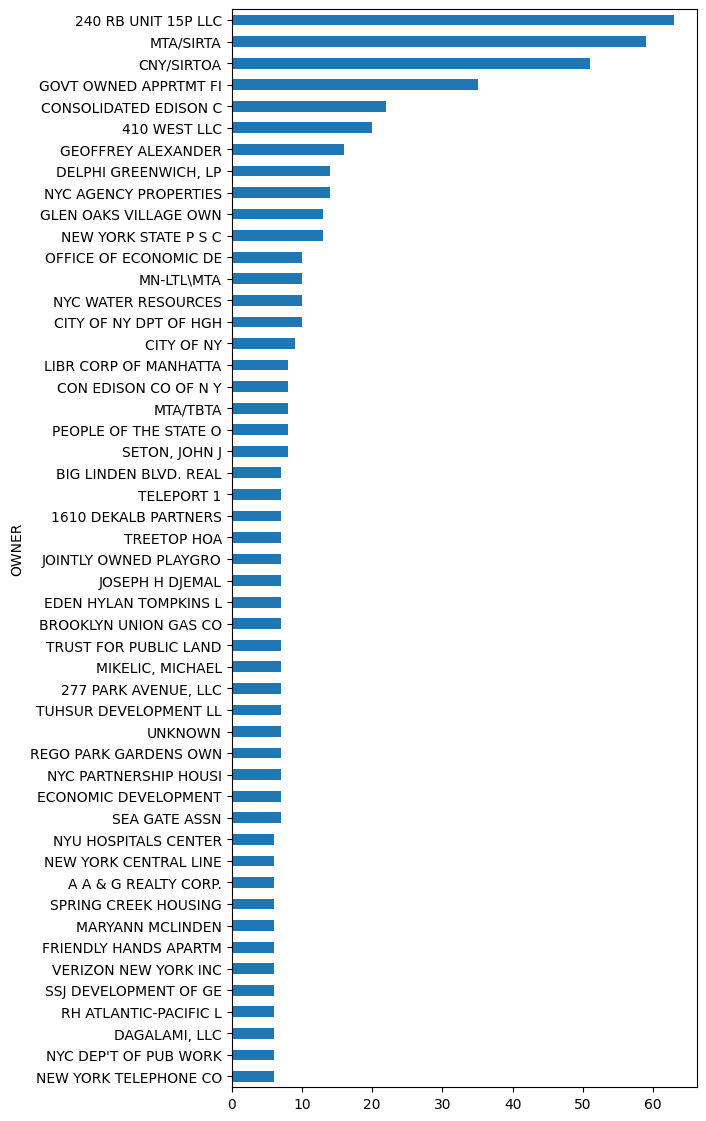

In [134]:
# you can look at this list and add some to the exclusions if you want
plt.figure(figsize=(6,14))
NY_data_top_n['OWNER'].value_counts().head(50).sort_values().plot(kind='barh')

In [135]:
NY_data_top_n.shape

(10000, 63)

In [136]:
NY_data_top_n.to_excel('NY_top_with_zs.xlsx', index=True)
NY_top_lotsize_ne_0 = NY_data_top_n[NY_data_top_n['LTFRONT'] != 0]
NY_top_lotsize_ne_0.to_excel('NY_top_lotsize_ne_0.xlsx', index=True)
NY_top_sizes_ne_0 = NY_top_lotsize_ne_0[NY_top_lotsize_ne_0['BLDDEPTH'] != 0]
NY_top_sizes_ne_0.to_excel('NY_top_sizes_ne_0.xlsx', index=True)

In [137]:
nfields = 34
data_base_vars = NY_data_top_n.iloc[:,nfields:nfields+9]
data_base_vars.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9
RECORD,,,,,,,,,
917942,-0.082279,127.772000,274.873084,8.219043,997.972287,1017.734254,17.758768,983.199735,1014.042956
1067360,50.705685,-0.029786,-0.030277,82.033701,-0.006904,-0.003705,117.777914,-0.007961,-0.003636
561383,-0.093369,88.128257,252.808570,0.080988,22.587793,30.719021,0.337481,24.444236,33.621904
1053832,-0.073614,6.906680,19.863632,0.127501,0.084129,0.120076,0.543357,0.028266,0.046182
398266,-0.095152,3.660551,10.176965,-0.061913,0.118593,0.160864,0.013574,0.044689,0.066188


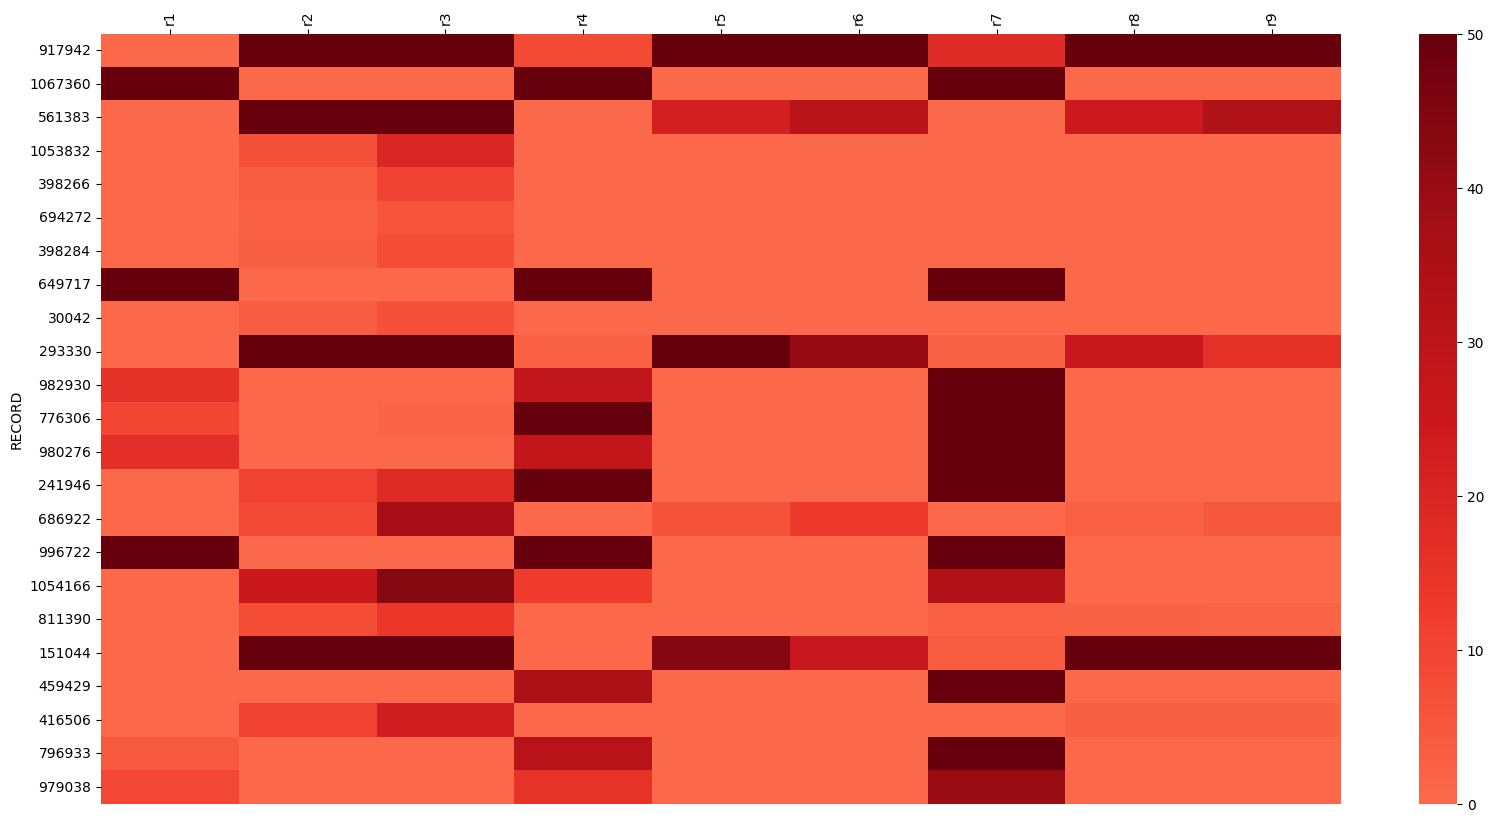

In [138]:
# The heatmaps are good for seeing which variables are driving the high scores
data_heatmap = data_base_vars.abs().head(23)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [139]:
data_all_vars = NY_data_top_n.iloc[:,nfields:]
data_all_vars.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r2_taxclass,r3_taxclass,r4_taxclass,r5_taxclass,r6_taxclass,r7_taxclass,r8_taxclass,r9_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,-0.082279,127.772000,274.873084,8.219043,997.972287,1017.734254,17.758768,983.199735,1014.042956,0.086546,...,14.797252,41.869926,3.455744,380.681061,626.655532,7.626936,349.766521,657.466678,12.040692,-0.029621
1067360,50.705685,-0.029786,-0.030277,82.033701,-0.006904,-0.003705,117.777914,-0.007961,-0.003636,60.442293,...,-0.017679,-0.019249,659.145627,-0.020313,-0.019278,604.232180,-0.018554,-0.017490,-0.110205,66.092759
561383,-0.093369,88.128257,252.808570,0.080988,22.587793,30.719021,0.337481,24.444236,33.621904,-0.053439,...,10.201703,38.507784,-0.093211,8.598934,18.898316,0.024632,8.680534,21.784521,0.260498,-0.029621
1053832,-0.073614,6.906680,19.863632,0.127501,0.084129,0.120076,0.543357,0.028266,0.046182,-0.072571,...,643.123297,665.604588,1.733939,275.649705,255.360493,3.197569,198.863332,188.477643,0.073000,-0.029621
398266,-0.095152,3.660551,10.176965,-0.061913,0.118593,0.160864,0.013574,0.044689,0.066188,-0.061370,...,342.145992,341.501570,0.213626,380.013774,339.512253,0.481490,289.020332,264.175803,-0.084083,-0.029621


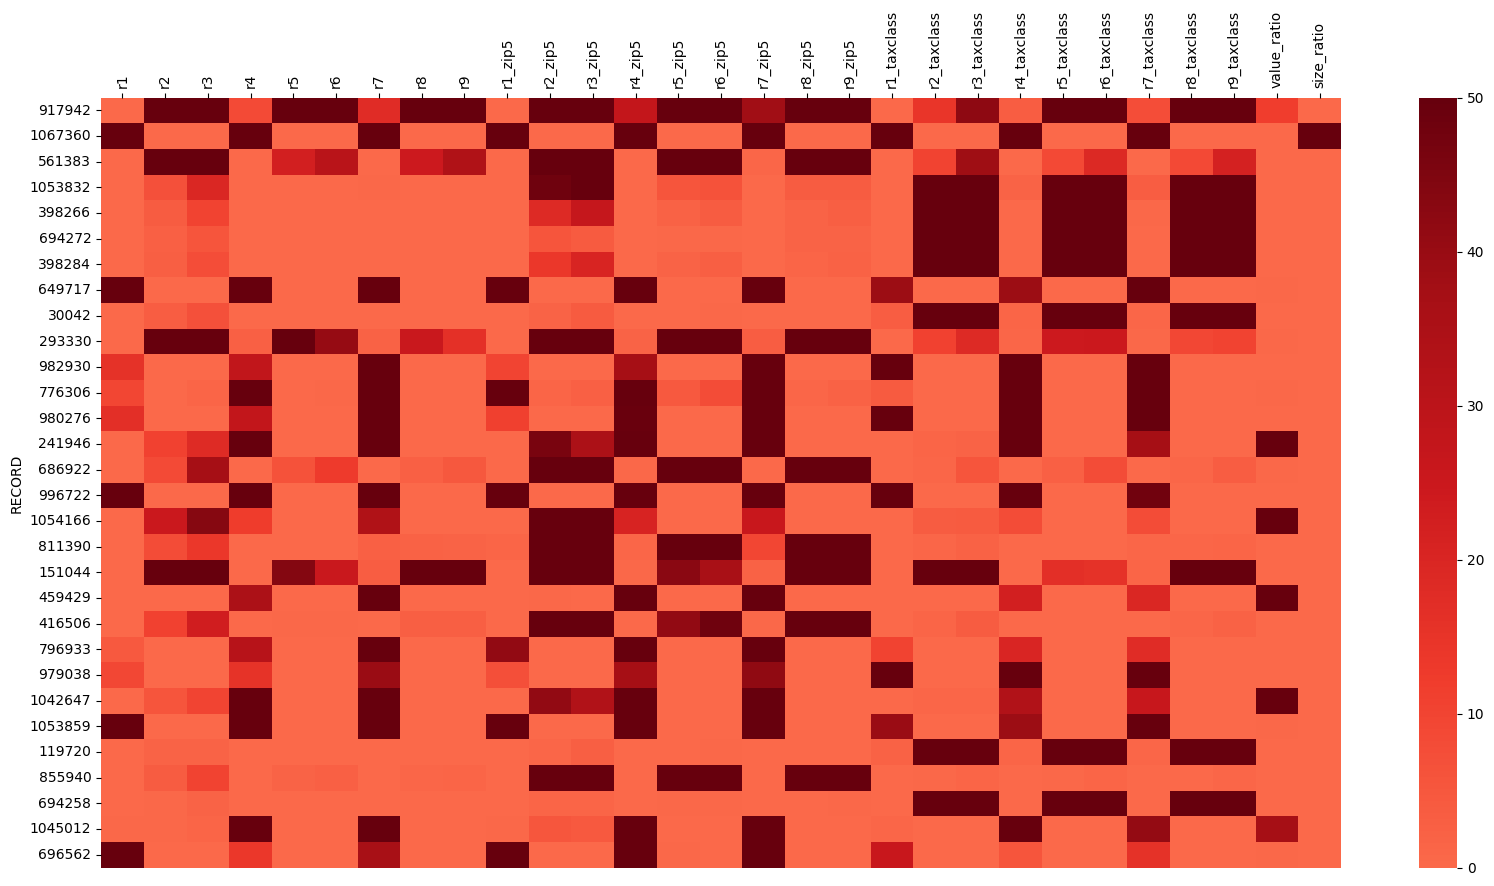

In [140]:
data_heatmap = data_all_vars.abs().head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [141]:
top_records_df = pd.DataFrame(top_records)

In [142]:
# Use this cell if you want to write out the top n record numbers
top_records_df.to_csv('top_n_record_numbers_baseline.csv', index=False)

In [143]:
# # Use this cell if you want to compare to a previous top n record numbers.
# # You can run a baseline model, see which records score the highest, then change some of the algorithm parameters
# # to see what % of these top scoring records change. The top records are insensitive to changes in the 
# # powers for the Minkowski distance measures for the two scores

# top_records_previous = pd.read_csv('top_n_record_numbers_baseline.csv')
# print(top_records_df.head())
# print(top_records_previous.head())
# num_common = len(pd.merge(top_records_df,top_records_previous, on='RECORD'))
# percent_common = 100*num_common/ntop
# percent_common

In [144]:
print('Duration: ', datetime.now() - start_time)

Duration:  0:01:25.218697
